In [4]:
# Импортируем библиотеки
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats as st
from scipy.stats import binom, norm
from math import factorial, sqrt

# Устанавливаем размер для всех графиков
plt.rcParams['figure.figsize'] = (10, 8)

**Резюме проекта**

**Заголовок:** Исследование данных мобильного приложения аренды самокатов GoFast

**Цель:** проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

**Вводная информация:**

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением.

Сервисом можно пользоваться:
* без подписки
    * абонентская плата отсутствует;
    * стоимость одной минуты поездки — 8 рублей;
    * стоимость старта (начала поездки) — 50 рублей;
* с подпиской Ultra
    * абонентская плата — 199 рублей в месяц;
    * стоимость одной минуты поездки — 6 рублей;
    * стоимость старта — бесплатно.

**Ход исследования:**
* Загрузка датасета и анализ общей информации
* Предобработка данных: выявление дубликатов, замена пропущенных значений, корректировка типов данных
* Исследовательский анализ данных: анализ популярности сервиса в разрезе городов, анализ возраста пользователей, анализ расстояния и продолжительности поездок
* Тестирование гипотез

**Общий вывод:** резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций.

#### Шаг 1. Загрузка данных

##### Считайте CSV-файлы с данными с помощью библиотеки pandas и сохраните их в датафреймы

In [5]:
# Подгружаем датасет с пользователями
users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv', sep=',')

# Подгружаем датасет с поездками
rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv', sep=',')

# Подгружаем датасет с подписками
subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv', sep=',')

##### Выведите первые строки каждого набора данных. Изучите общую информацию о каждом датафрейме

###### Users

In [6]:
# Выведем на экран первые строки датасета users
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [7]:
# Ознакомимся с данными
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


###### Rides

In [8]:
# Выведем на экран первые строки датасета rides
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [9]:
# Ознакомимся с данными
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [10]:
# Проверим период сбора данных
rides['date'].value_counts().sort_values()

,count
date,
2021-07-03,31
2021-02-02,34
2021-12-15,34
2021-07-30,35
2021-11-07,35
...,...
2021-08-20,67
2021-06-09,67
2021-12-27,69


###### Subscriptions

In [11]:
# Выведем на экран первые строки датасета subs
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [12]:
# Ознакомимся с данными
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


##### Промежуточные выводы

* Объема датасета **`users`** 1_565 строк
* В столбцах отсутствуют пропущенные значения
* Тип данных в столбцах корректный
* Наименования столбцов прописаны корректно
* Столбец `user_id` также есть в датасете **`rides`**, столбец `subscription_type` - в датасете **`subscriptions`**
---
* Объема датасета **`rides`** 18_068 строк
* В столбцах отсутствуют пропущенные значения
* Тип данных в столбце `date` подлежит корректировке на тип datetime
* Наименования столбцов прописаны корректно
* Столбец `user_id` также есть в датасете **`users`**
---
* Объема датасета **`subscriptions`** 2 строки
* В столбцах отсутствуют пропущенные значения
* Тип данных в столбцах корректный
* Наименования столбцов прописаны корректно
* Столбец `subscription_type` также есть в датасете **`users`**

#### Шаг 2. Предобработка данных

##### Изменение типов данных по столбцам

In [13]:
# Корректируем тип данных для столбца с датой
rides['date'] = pd.to_datetime(rides['date'])

# Проверка типов данных в датасете
rides.dtypes

,0
user_id,int64
distance,float64
duration,float64
date,datetime64[ns]


##### Создание новых столбцов

In [14]:
# Комментарий ревьюера 2
rides['date'].dt.year.unique()

array([2021], dtype=int32)

In [15]:
# Создаем новый столбец с номером месяца
rides['date_month'] = rides['date'].dt.month

# Смотрим на результат
rides.head()

,user_id,distance,duration,date,date_month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


##### Обработка пропущенных значений и дубликатов

###### Users

In [16]:
# Проверим наличие дубликатов
users.duplicated().sum()

np.int64(31)

In [17]:
# Удалим явные дубликаты из датасета
users.drop_duplicates(keep='first', inplace=True)

In [18]:
# Проверим результат удаления дубликатов
users.duplicated().sum()

np.int64(0)

In [19]:
# Проверим столбец name на наличие неявных дубликатов
users['name'].sort_values().unique()

array(['Агата', 'Аделина', 'Адель', 'Айдар', 'Александр', 'Александра',
       'Алексей', 'Алина', 'Алиса', 'Алия', 'Алла', 'Альберт', 'Альбина',
       'Алёна', 'Амалия', 'Амина', 'Амир', 'Анастасия', 'Анатолий',
       'Ангелина', 'Андрей', 'Анжелика', 'Анна', 'Антон', 'Антонина',
       'Ариана', 'Арина', 'Арсен', 'Арсений', 'Артемий', 'Артур', 'Артём',
       'Богдан', 'Борис', 'Вадим', 'Валентина', 'Валерий', 'Валерия',
       'Варвара', 'Василий', 'Василина', 'Василиса', 'Вера', 'Вероника',
       'Виктор', 'Виктория', 'Виолетта', 'Виталий', 'Виталина', 'Влад',
       'Влада', 'Владимир', 'Владислав', 'Владислава', 'Всеволод',
       'Вячеслав', 'Галина', 'Георгий', 'Герман', 'Глеб', 'Гордей',
       'Григорий', 'Давид', 'Дамир', 'Даниил', 'Данил', 'Данила',
       'Даниэль', 'Дарина', 'Дарья', 'Демид', 'Денис', 'Диана', 'Дмитрий',
       'Ева', 'Евгений', 'Евгения', 'Егор', 'Екатерина', 'Елена',
       'Елизавета', 'Елисей', 'Есения', 'Жанна', 'Зарина', 'Захар',
       'Злата', 

In [20]:
# Проверим столбец city на наличие неявных дубликатов
users['city'].sort_values().unique()

array(['Екатеринбург', 'Краснодар', 'Москва', 'Омск', 'Пятигорск',
       'Ростов-на-Дону', 'Сочи', 'Тюмень'], dtype=object)

###### Rides

In [21]:
# Проверим наличие явных дубликатов
rides.duplicated().sum()

np.int64(0)

###### Subscriptions

In [22]:
# Проверим наличие явных дубликатов
subscriptions.duplicated().sum()

np.int64(0)

##### Промежуточные выводы

* В датасете **`rides`** тип данных для столбца `date` скорректирован на datetime
* В датасете **`rides`** создан новый столбец `date_month`
* В датасете **`users`** удалён 31 явный дубликат
* Пропущенные значения в датасетах не выявлены (см. п.1.2)

#### Шаг 3. Исследовательский анализ данных

Опишите и визуализируйте общую информацию о пользователях и поездках:

##### Анализ - частота встречаемости городов

In [23]:
# Группируем данные
users_city_count = users.groupby('city').size().sort_values().reset_index() \
.rename(columns={0: 'city_count'})

# Выводим результат
users_city_count

,city,city_count
0,Москва,168
1,Тюмень,180
2,Омск,183
3,Сочи,189
4,Краснодар,193
5,Ростов-на-Дону,198
6,Екатеринбург,204
7,Пятигорск,219


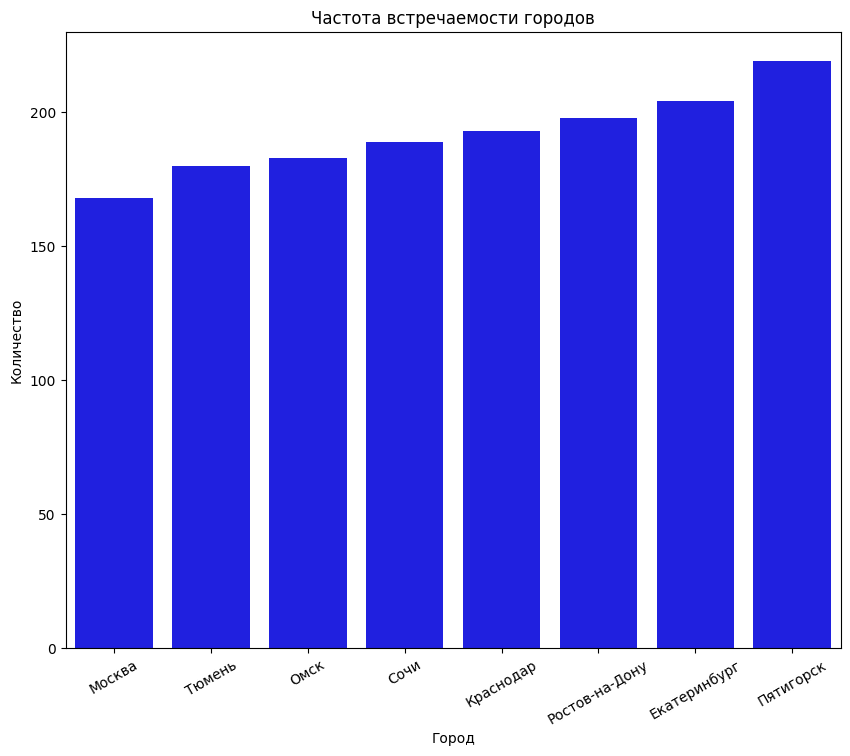

In [24]:
# Создание гистограммы
sns.barplot(data=users_city_count, x='city', y='city_count', color='blue')

# Заголовок и подписи осей
plt.title('Частота встречаемости городов')
plt.xlabel('Город')
plt.ylabel('Количество')

# Добавим наклон для подписей оси X:
plt.xticks(rotation=30)

plt.show()

**Комментарий к графику:** чаще всего встречаются пользователи из Пятигорска, реже всего - из Москвы

##### Анализ - соотношение пользователей с подпиской и без подписки

In [26]:
# Группируем данные
users_subscription_count = users.groupby('subscription_type').size().sort_values().reset_index() \
.rename(columns={0: 'subscription_count'})

# Добавляем доли
users_subscription_count['subscription_share'] = users_subscription_count['subscription_count'] / users_subscription_count['subscription_count'].sum()

# Выводим результат
users_subscription_count

,subscription_type,subscription_count,subscription_share
0,ultra,699,0.455671
1,free,835,0.544329


In [27]:
# Создадим график:
fig = px.pie(users_subscription_count, values='subscription_share', names='subscription_type',
             title='Соотношение пользователей с подпиской и без')

# Добавим подпись на график:
fig.update_traces(textinfo='label+percent')
fig.show()

**Комментарий к графику:** пользователи с подпиской составляют 54,4%, без подписки - 45,6%.

##### Анализ - возраст пользователей

In [28]:
# Посмотрим на распределение возраста
users['age'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

,age
count,1534.000000
mean,24.903520
std,4.572367
min,12.000000
25%,22.000000
50%,25.000000
75%,28.000000
95%,33.000000
99%,35.000000
max,43.000000


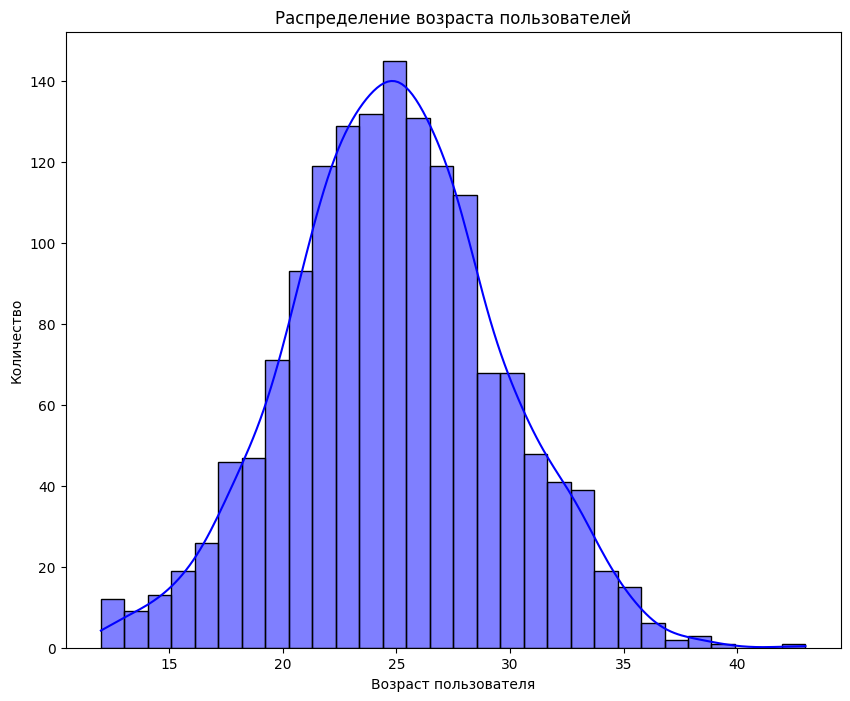

In [29]:
# Создание гистограммы
sns.histplot(data=users, x='age', kde=True, color='blue')

# Заголовок и подписи осей
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст пользователя')
plt.ylabel('Количество')

plt.show()

**Комментарий к графику:** распределение возраста пользователей имеет пиковое значение на отметке 25 лет. Таким образом, целевая аудитория это пользователи в возрасте от 23 до 27 лет.

##### Анализ - расстояние, которое пользователь преодолел за одну поездку

In [30]:
# Посмотрим на распределение
rides['distance'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

,distance
count,18068.000000
mean,3070.659976
std,1116.831209
min,0.855683
25%,2543.226360
50%,3133.609994
75%,3776.222735
95%,4740.088596
99%,5478.621528
max,7211.007745


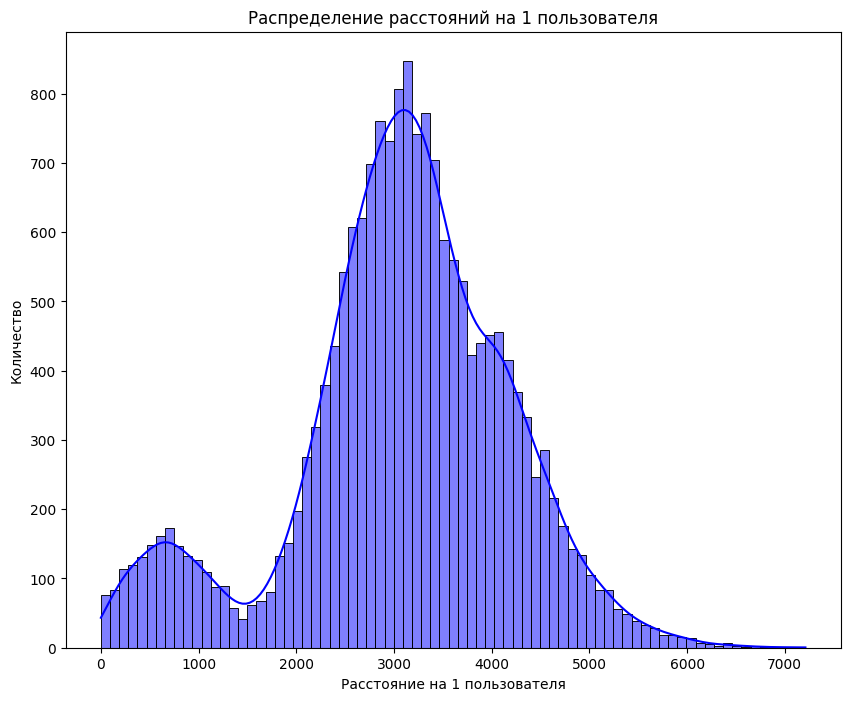

In [31]:
# Создание гистограммы
sns.histplot(data=rides, x='distance', kde=True, color='blue')

# Заголовок и подписи осей
plt.title('Распределение расстояний на 1 пользователя')
plt.xlabel('Расстояние на 1 пользователя')
plt.ylabel('Количество')

plt.show()

**Комментарий к графику:** распределение расстояний на 1 пользователя имеет пиковые значения в интервале от 2900 м до 3300 м (в среднем 3 км). Есть также локальный пик в интервале 500 м - 1000 м. Это могут быть пользователи, которым нужно быстро доехать до автобусной остановки или метро. А может, это пользователи, которым не понравилось состояние самоката.

##### Анализ - продолжительность поездок

In [32]:
# Посмотрим на распределение
rides['duration'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

,duration
count,18068.000000
mean,17.805011
std,6.091051
min,0.500000
25%,13.597563
50%,17.678395
75%,21.724800
95%,28.428730
99%,32.503580
max,40.823963


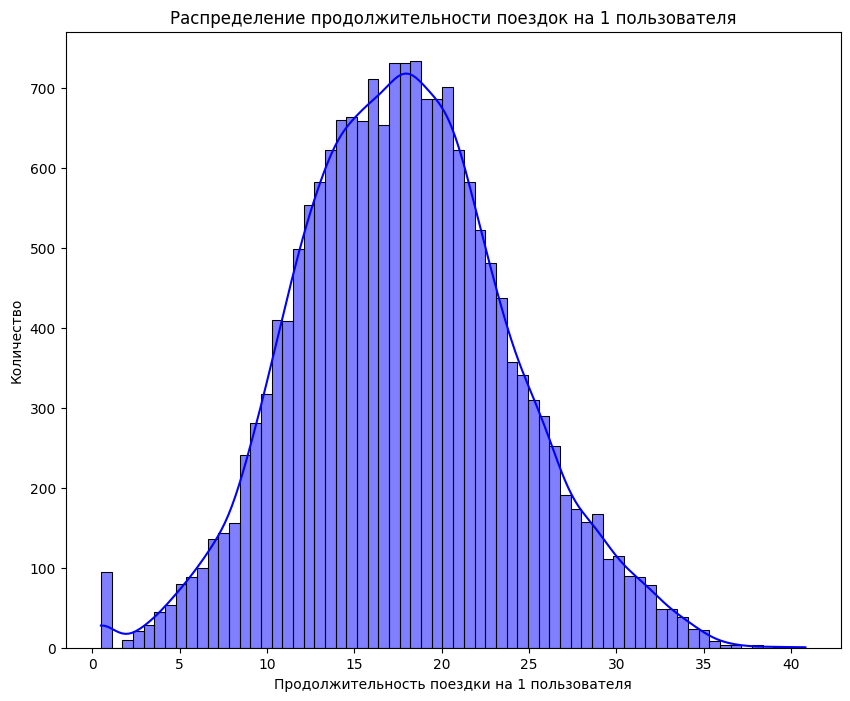

In [33]:
# Создание гистограммы
sns.histplot(data=rides, x='duration', kde=True, color='blue')

# Заголовок и подписи осей
plt.title('Распределение продолжительности поездок на 1 пользователя')
plt.xlabel('Продолжительность поездки на 1 пользователя')
plt.ylabel('Количество')

plt.show()

**Комментарий к графику:** распределение продолжительности поездок на 1 пользователя имеет пиковые значения в интервале 12-22 минуты. Есть также локальный пик в области 2 минут. Это могут быть пользователи, которым не понравилось состояние самоката или опыт езды (возможно, новички).

##### Промежуточные выводы

* Анализ пользователей по городам показал, что **чаще всего встречаются пользователи из Пятигорска, реже всего - из Москвы**.

* Анализ пользователей в рарезе наличия подписки показал, что **пользователи с подпиской составляют 54,4%, без подписки - 45,6%.**.

* Анализ возраста пользователей показал, что распределение возраста пользователей имеет пиковое значение на отметке 25 лет. Таким образом, **целевая аудитория это пользователи в возрасте от 23 до 27 лет**. Также есть пользователи в возрасте до 18 лет, которые по возрасту не должны ездить на самокатах.

* Анализ расстояний поездок показал, что **в среднем 1 пользователь проезжает 3 км**. Примечательно, что практически не встречаются пользователя, которые ездят более 6 км.

* Анализ средней продолжительности поездки показал, что **в среднем продолжительность поездки на 1 пользователя составляет 18 минут**.

#### Шаг 4. Объединение данных

##### Объединение данных о пользователях, поездках и подписках

In [34]:
# Сначала объединим датасеты Users и Rides
df_users_rides = pd.merge(users, rides, on='user_id')

# Затем объединим получвшийся датафрейм с датасетом Subscriptions
df_merged = pd.merge(df_users_rides, subscriptions, on='subscription_type')

# Смотрим на результат
df_merged.head()

,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [35]:
# Посмотрим на общую информацию
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   date_month         18068 non-null  int32         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB


##### Создание дополнительных датафреймов

###### Данные о пользователях без подписки

In [36]:
# Создаем датасет с пользователями без подписки
free_users = df_merged.loc[df_merged['subscription_type'] == 'free'].copy()

# Выводим результат
free_users.head()

,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


In [37]:
# Проверяем, что индексация сработала корректно
free_users['subscription_type'].value_counts()

,count
subscription_type,
free,11568


###### Данные о пользователях с подпиской

In [38]:
# Создаем датасет с пользователями без подписки
subscribed_users = df_merged.loc[df_merged['subscription_type'] == 'ultra'].copy()

# Выводим результат
subscribed_users.head()

,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [39]:
# Проверяем, что индексация сработала корректно
subscribed_users['subscription_type'].value_counts()

,count
subscription_type,
ultra,6500


##### Визуализация информации о расстоянии и времени поездок для пользователей обеих категорий

###### Расстояние поездок для пользователей <u>без подписки</u>

In [40]:
# Посмотрим на распределение
free_users['distance'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

,distance
count,11568.000000
mean,3045.495282
std,1246.173806
min,0.855683
25%,2366.562689
50%,3114.648465
75%,3905.697894
95%,4934.728012
99%,5652.323762
max,7211.007745


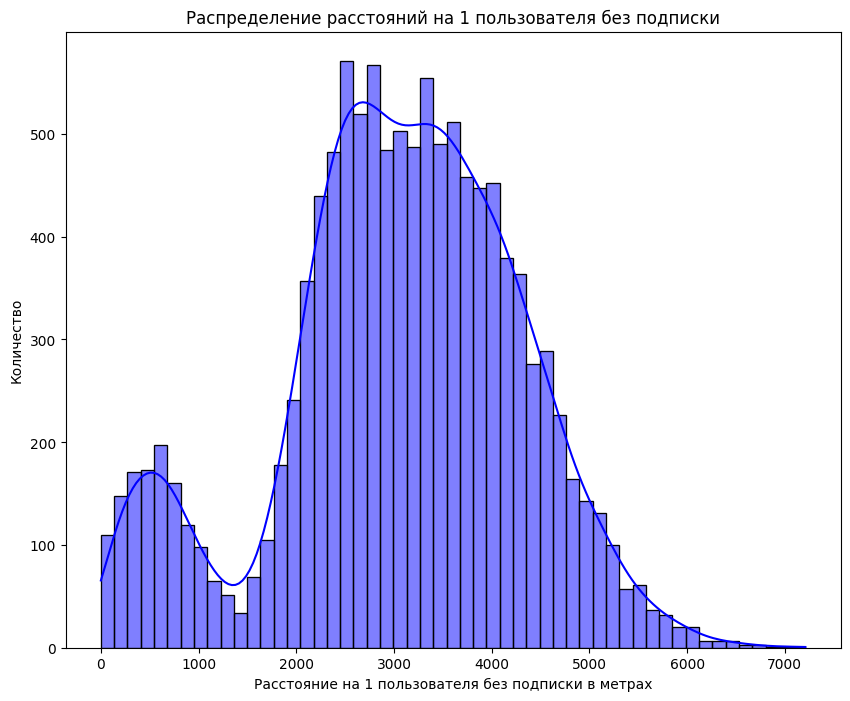

In [41]:
# Создание гистограммы
sns.histplot(data=free_users, x='distance', kde=True, color='blue')

# Заголовок и подписи осей
plt.title('Распределение расстояний на 1 пользователя без подписки')
plt.xlabel('Расстояние на 1 пользователя без подписки в метрах')
plt.ylabel('Количество')

plt.show()

**Комментарий к графику:** распределение расстояний поездок на 1 пользователя <u>без подписки</u> показывает пик в интервале 2500-3500 метров. Также есть локальный пик в области 500 метров. Скорее всего это пользователи - новички с отрицательным пользовательским опытом.

###### Расстояние поездок для пользователей <u>с подпиской</u>

In [42]:
# Посмотрим на распределение
subscribed_users['distance'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

,distance
count,6500.000000
mean,3115.445388
std,836.895330
min,244.210438
25%,2785.444017
50%,3148.637229
75%,3560.574425
95%,4382.285625
99%,4804.456446
max,5699.769662


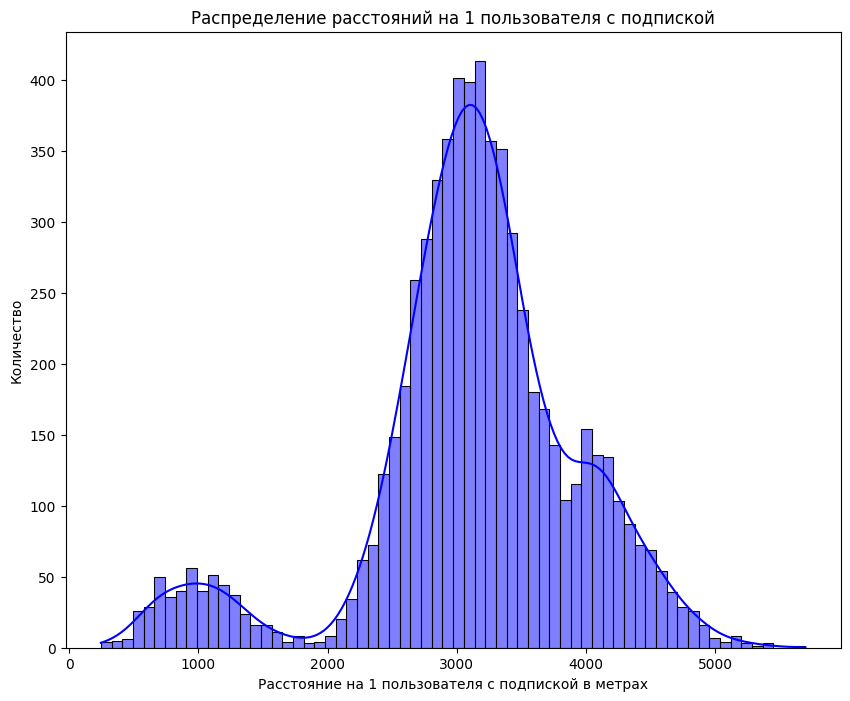

In [43]:
# Создание гистограммы
sns.histplot(data=subscribed_users, x='distance', kde=True, color='blue')

# Заголовок и подписи осей
plt.title('Распределение расстояний на 1 пользователя с подпиской')
plt.xlabel('Расстояние на 1 пользователя с подпиской в метрах')
plt.ylabel('Количество')

plt.show()

**Комментарий к графику:** распределение расстояний на 1 пользователя <u>с подпиской</u> показывает пик в интервале 2800-3200 метров. Есть также локальный пик в области 1000 метров.

###### Расстояние поездок для пользователей (сводная диаграмма)

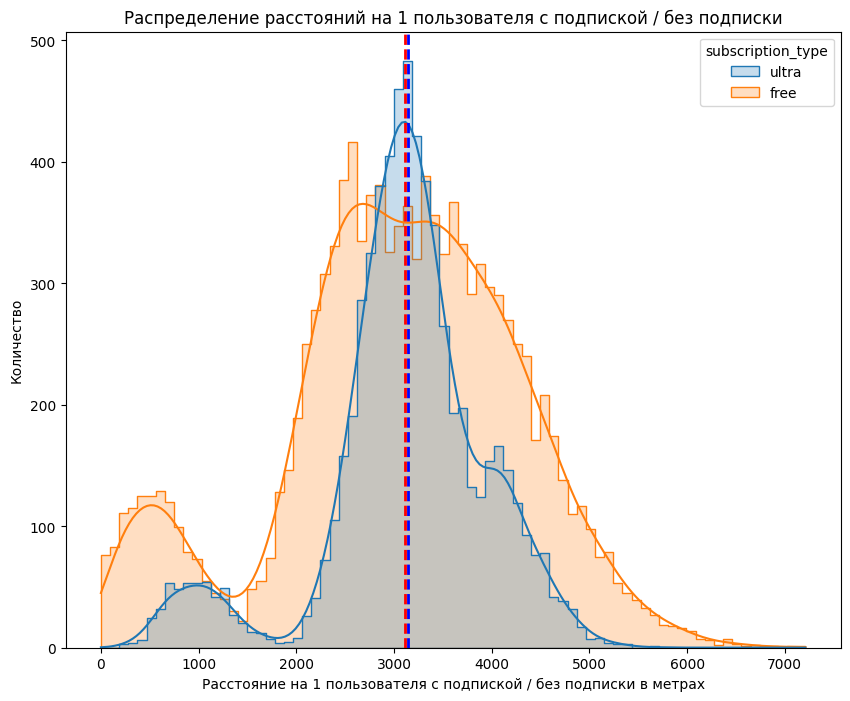

In [44]:
# Создание гистограммы
sns.histplot(data=df_merged, x='distance', hue='subscription_type', kde=True, element='step')

# Выисляем медиану
median_free_users = free_users['distance'].median()
median_subscribed_users = subscribed_users['distance'].median()

# Добавляем линии медианы
plt.axvline(
    median_free_users,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Медиана без подписки: {median_free_users:.2f}'
)

plt.axvline(
    median_subscribed_users,
    color='blue',
    linestyle='--',
    linewidth=2,
    label=f'Медиана с подпиской: {median_subscribed_users:.2f}'
)


# Заголовок и подписи осей
plt.title('Распределение расстояний на 1 пользователя с подпиской / без подписки')
plt.xlabel('Расстояние на 1 пользователя с подпиской / без подписки в метрах')
plt.ylabel('Количество')

plt.show()

**Комментарий к графику:**
* Медианы распределения расстояния поездок для двух групп пользователей практически совпадают.
* Распределение расстояния поездок на 1 пользователя <u>с подпиской</u> имеет более узкий интервал пиковых значений (2800-3200 м) относительно пользователей <u>без подписки</u> (2500-3500 м).
* Кроме того, для пользователей <u>без подписки</u> характерно бОльшее количество поездок до 1000 метров, что может объясняться новыми пользователями с отрицательным опытом езды на самокате.

###### Продолжительность поездок для пользователей <u>без подписки</u>

In [45]:
# Посмотрим на распределение
free_users['duration'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

,duration
count,11568.000000
mean,17.390909
std,6.326803
min,0.500000
25%,12.958437
50%,17.326890
75%,21.594071
95%,28.246500
99%,32.272371
max,34.948498


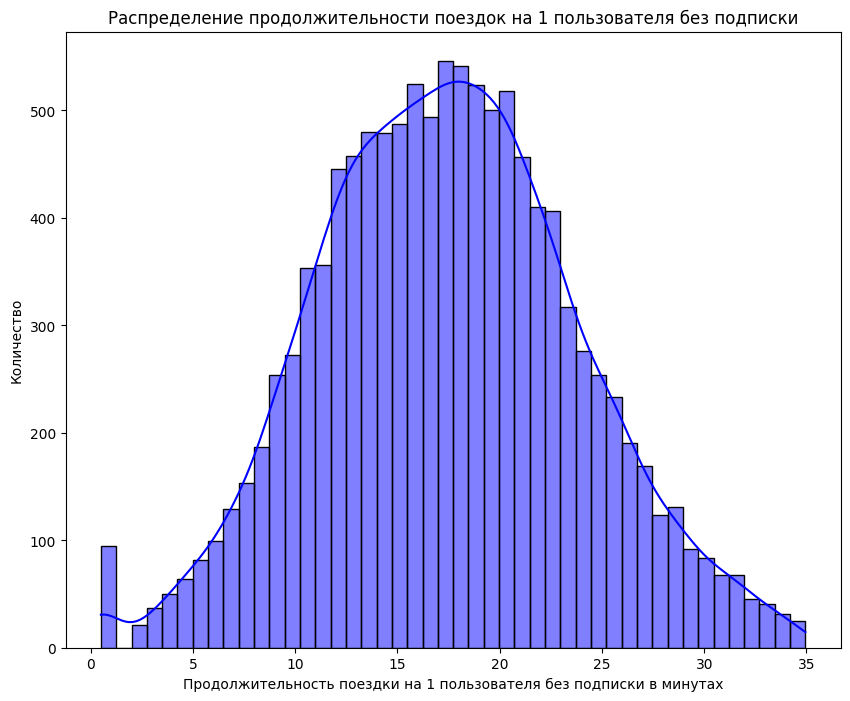

In [46]:
# Создание гистограммы
sns.histplot(data=free_users, x='duration', kde=True, color='blue')

# Заголовок и подписи осей
plt.title('Распределение продолжительности поездок на 1 пользователя без подписки')
plt.xlabel('Продолжительность поездки на 1 пользователя без подписки в минутах')
plt.ylabel('Количество')

plt.show()

**Комментарий к графику:** распределение продолжительности поездок на 1 пользователя <u>без подписки</u> имеет пиковые значения в интервале 14-22 минуты.

###### Продолжительность поездок для пользователей <u>с подпиской</u>

In [47]:
# Посмотрим на распределение
subscribed_users['duration'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

,duration
count,6500.000000
mean,18.541985
std,5.572048
min,3.760353
25%,14.524654
50%,18.178153
75%,21.884129
95%,28.720878
99%,33.009326
max,40.823963


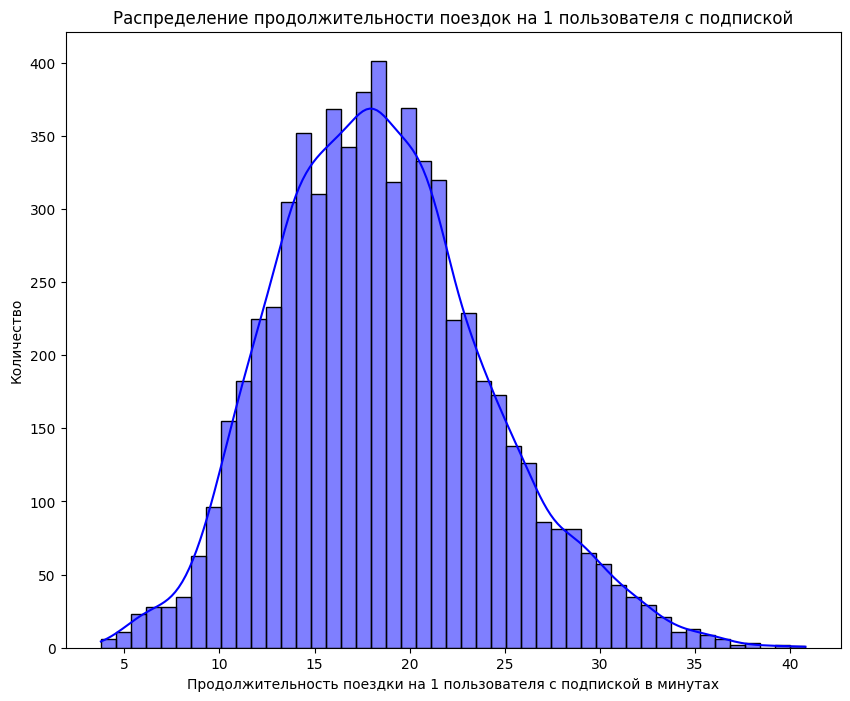

In [48]:
# Создание гистограммы
sns.histplot(data=subscribed_users, x='duration', kde=True, color='blue')

# Заголовок и подписи осей
plt.title('Распределение продолжительности поездок на 1 пользователя с подпиской')
plt.xlabel('Продолжительность поездки на 1 пользователя с подпиской в минутах')
plt.ylabel('Количество')

plt.show()

**Комментарий к графику:** распределение продолжительности поездок на 1 пользователя <u>с подпиской</u> имеет пиковые значения в интервале 17-22 минуты. В отличие от поездок пользователей <u>без подписки</u> здесь есть продолжительность более 35 минут.

###### Продолжительность поездок (сводная диаграмма)

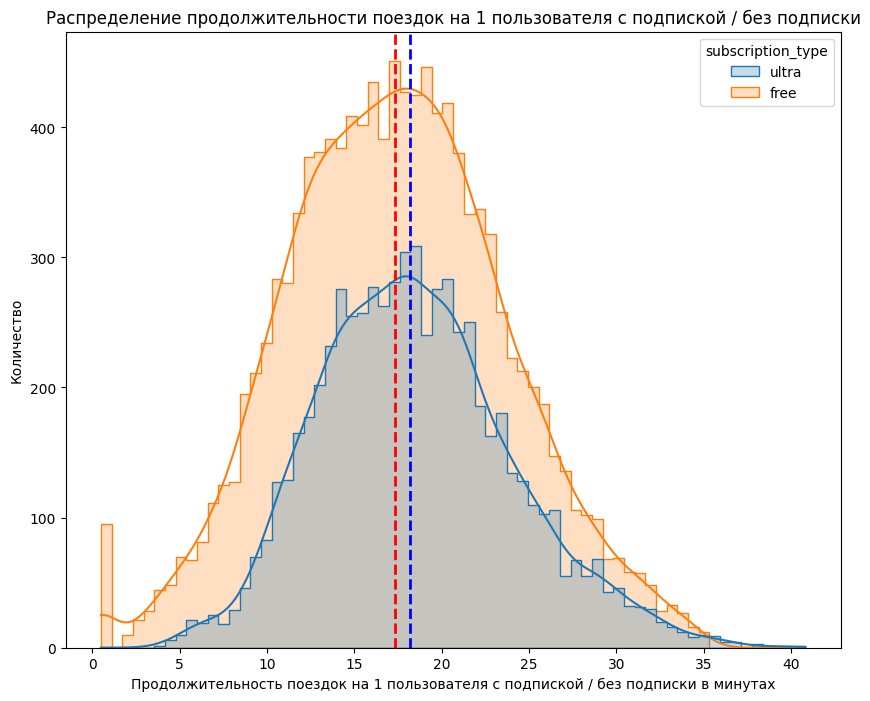

In [49]:
# Создание гистограммы
sns.histplot(data=df_merged, x='duration', hue='subscription_type', kde=True, element='step')

# Выисляем медиану
median_free_users = free_users['duration'].median()
median_subscribed_users = subscribed_users['duration'].median()

# Добавляем линии медианы
plt.axvline(
    median_free_users,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Медиана без подписки: {median_free_users:.2f}'
)

plt.axvline(
    median_subscribed_users,
    color='blue',
    linestyle='--',
    linewidth=2,
    label=f'Медиана с подпиской: {median_subscribed_users:.2f}'
)


# Заголовок и подписи осей
plt.title('Распределение продолжительности поездок на 1 пользователя с подпиской / без подписки')
plt.xlabel('Продолжительность поездок на 1 пользователя с подпиской / без подписки в минутах')
plt.ylabel('Количество')

plt.show()

**Комментарий к графику:**
* Медианы распределения продолжительности поездок для двух групп пользователей различаются.
* Распределение продолжительности поездок на 1 пользователя <u>с подпиской</u> имеет более узкий интервал пиковых значений (17-22 мин.) относительно пользователей <u>без подписки</u> (14-22 мин.).
* Кроме того, для пользователей <u>без подписки</u> характерно бОльшее количество поездок до 2 минут, что может объясняться новыми пользователями с отрицательным опытом езды на самокате.

##### Промежуточные выводы

По итогам шага 4:
* в единый датафрейм объединены датасеты `users`, `rides`, `subscriptions`.
* разделены на 2 датафрейма данные по пользователям с подпиской и без подписки.
* построены гистограммы распределения расстояний и продолжительности поездок по пользователям с подпиской и без подписки.

На основе построенных графиков можно сделать следующие выводы:
* среднее расстояние поездки на 1 пользователя <u>без подписки</u> составляет 3114 метров, <u>с подпиской</u> - 3148 метра.
* средняя продолжительность поездки на 1 пользователя <u>без подписки</u> составляет 17 минут, <u>с подпиской</u> - 18 минут.

#### Шаг 5. Подсчёт выручки

##### Создание датафрейма с агрегированными данными о поездках

Найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц

In [50]:
# Выведем на экран сводный датафрейм
df_merged.head()

,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [51]:
# Округляем длительность поездок
df_merged['duration'] = np.ceil(df_merged['duration'])

# Смотрим на результат
df_merged.head()

,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199


In [52]:
# Построим сводную таблицу
df_merged_user_agg = df_merged.pivot_table(
    index=['user_id', 'date_month', 'subscription_type'],
    values=['distance', 'duration', 'date'],
    aggfunc={
        'distance':'sum',
        'duration':'sum',
        'date':'count'
    }).reset_index().rename(columns={'distance':'total_distance', 'date':'ride_count', 'duration':'total_duration'})


# Смотрим на результат
df_merged_user_agg.head()

,user_id,date_month,subscription_type,ride_count,total_distance,total_duration
0,1,1,ultra,2,7027.511294,42.0
1,1,4,ultra,1,754.159807,7.0
2,1,8,ultra,2,6723.470560,46.0
3,1,10,ultra,2,5809.911100,32.0
4,1,11,ultra,3,7003.499363,56.0


In [53]:
df_merged_user_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11331 entries, 0 to 11330
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            11331 non-null  int64  
 1   date_month         11331 non-null  int32  
 2   subscription_type  11331 non-null  object 
 3   ride_count         11331 non-null  int64  
 4   total_distance     11331 non-null  float64
 5   total_duration     11331 non-null  float64
dtypes: float64(2), int32(1), int64(2), object(1)
memory usage: 487.0+ KB


##### Добавление столбца с помесячной выручкой, которую принёс каждый пользователь

Для этого обратитесь к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа: например, значения 25.3, 25.5 и 26.0 должны быть преобразованы к 26.

In [54]:
# Объединим новый датафрейм с датасетом по подпискам
df_merged_revenue = pd.merge(df_merged_user_agg, subscriptions, on='subscription_type')

# Выведем на экран
df_merged_revenue.head()

,user_id,date_month,subscription_type,ride_count,total_distance,total_duration,minute_price,start_ride_price,subscription_fee
0,1,1,ultra,2,7027.511294,42.0,6,0,199
1,1,4,ultra,1,754.159807,7.0,6,0,199
2,1,8,ultra,2,6723.470560,46.0,6,0,199
3,1,10,ultra,2,5809.911100,32.0,6,0,199
4,1,11,ultra,3,7003.499363,56.0,6,0,199


In [55]:
# Посчитаем помесячную выручку по каждому пользователю
df_merged_revenue['month_revenue_per_user'] = df_merged_revenue['start_ride_price'] * df_merged_revenue['ride_count'] \
+ df_merged_revenue['minute_price'] * df_merged_revenue['total_duration'] + df_merged_revenue['subscription_fee']

# Выводим датасет с учетом нового столбца на экран
df_merged_revenue.head()

,user_id,date_month,subscription_type,ride_count,total_distance,total_duration,minute_price,start_ride_price,subscription_fee,month_revenue_per_user
0,1,1,ultra,2,7027.511294,42.0,6,0,199,451.0
1,1,4,ultra,1,754.159807,7.0,6,0,199,241.0
2,1,8,ultra,2,6723.470560,46.0,6,0,199,475.0
3,1,10,ultra,2,5809.911100,32.0,6,0,199,391.0
4,1,11,ultra,3,7003.499363,56.0,6,0,199,535.0


##### Промежуточные выводы

* Создан датафрейм с агрегированными данными о поездках и посчитаны <u>для каждого пользователя за каждый месяц</u>:
    * выручка;
    * суммарное расстояние поездок;
    * суммарное время поездок;
    * количество поездок.

#### Шаг 6. Проверка гипотез

#####  Пользователи с подпиской тратят больше времени на поездки

Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки

Сформулируем нулевую гипотезу Н<sub>0</sub>: среднее время поездки на 1 пользователя <u>с подпиской</u> **равно** среднему времени поездки на 1 пользователя <u>без подписки</u>

Сформулируем альтернативную гипотезу Н<sub>1</sub>: среднее время поездки на 1 пользователя <u>с подпиской</u> **больше** среднего времени поездки на 1 пользователя <u>без подписки</u>

Для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам воспользуемся методом `scipy.stats.ttest_ind()`: эти выборки не зависят друг от друга, выборочные средние распределны нормально

Альтернативная гипотеза односторонняя

In [57]:
# Определяем выборки для сравнения
subscribed_users_duration = subscribed_users['duration']
free_users_duration = free_users['duration']

# Определяем уровень статистической значимости
alpha = 0.05

# Воспользуемся выбранным тестом
results = st.ttest_ind(subscribed_users_duration, free_users_duration, alternative='greater')

# Выводим на экран p_value
print('p-значение:', results.pvalue)

# Пишем условие проверки гипотезы
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: среднее время поездки 1 пользователя с подпиской значимо больше',
          'аналогичного показателя для пользователя без подписки')
else:
    print('Не отвергаем нулевую гипотезу: нет значимой разницы между средним временем поездки 1 пользователя с подпиской',
          'и без подписки')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу: среднее время поездки 1 пользователя с подпиской значимо больше аналогичного показателя для пользователя без подписки


##### Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката.

Сформулируем нулевую гипотезу Н<sub>0</sub>: среднее расстоение поездки на 1 пользователя <u>с подпиской</u> **равно или меньше** 3130 метров

Сформулируем альтернативную гипотезу Н<sub>1</sub>: среднее расстоение поездки на 1 пользователя <u>с подпиской</u> **больше** 3130 метров

Альтернативная гипотеза односторонняя. Для проведения одностороннего теста используем метод `scipy.stats.ttest_1samp()`

In [58]:
# Определяем выборку для проведения теста
subscribed_users_distance = subscribed_users['distance']

# Определяем целевое значение для сравнения
target_distance = 3130

# Определяем уровень статистической значимости
alpha = 0.05

# Воспользуемся выбранным тестом
results = st.ttest_1samp(subscribed_users_distance, target_distance, alternative='greater')

# Выводим на экран p_value
print('p-значение:', results.pvalue)

# Пишем условие проверки гипотезы
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: среднее расстояние поездки 1 пользователя с подпиской значимо больше 3130 метров')
else:
    print('Не отвергаем нулевую гипотезу: нет достаточных оснований утверждать, что среднее расстояние поездки 1 пользователя',
          'с подпиской значимо больше 3130 метров')

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу: нет достаточных оснований утверждать, что среднее расстояние поездки 1 пользователя с подпиской значимо больше 3130 метров


#####  Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

Сформулируем нулевую гипотезу Н<sub>0</sub>: помесячная выручка от пользователей <u>с подпиской</u> **равна** помесячной выручке от пользователей <u>без подписки</u>

Сформулируем альтернативную гипотезу Н<sub>1</sub>: помесячная выручка от пользователей <u>с подпиской</u> **больше** помесячной выручки от пользователей <u>без подписки</u>

Для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам воспользуемся методом `scipy.stats.ttest_ind()`: эти выборки не зависят друг от друга

Альтернативная гипотеза односторонняя

В пункт 5.2 мы уже считали помесячную выручку на каждого пользователя. Воспользуемся этой информацией.

###### Считаем помесячную выручку от пользователей <u>с подпиской</u>

In [59]:
# Посчитаем помесячную выручку
subscripted_users_month_revenue = (
    df_merged_revenue
    .query('subscription_type == "ultra"')
    .groupby(['user_id', 'date_month'])
    .agg({'month_revenue_per_user':'sum'})
    .rename(columns={'month_revenue_per_user':'month_revenue_per_user_total'})
    .reset_index()
)

# Выводим на экран
subscripted_users_month_revenue

,user_id,date_month,month_revenue_per_user_total
0,1,1,451.0
1,1,4,241.0
2,1,8,475.0
3,1,10,391.0
4,1,11,535.0
...,...,...,...
4528,699,6,301.0
4529,699,8,469.0
4530,699,9,385.0
4531,699,10,295.0


###### Считаем помесячную выручку от пользователей <u>без подписки</u>

In [60]:
# Посчитаем помесячную выручку
free_users_month_revenue = (
    df_merged_revenue
    .query('subscription_type == "free"')
    .groupby(['user_id', 'date_month'])
    .agg({'month_revenue_per_user':'sum'})
    .rename(columns={'month_revenue_per_user':'month_revenue_per_user_total'})
    .reset_index()
)

# Выводим на экран
free_users_month_revenue

,user_id,date_month,month_revenue_per_user_total
0,700,1,170.0
1,700,2,962.0
2,700,3,202.0
3,700,4,178.0
4,700,6,332.0
...,...,...,...
6793,1534,6,308.0
6794,1534,8,484.0
6795,1534,9,234.0
6796,1534,11,824.0


###### Проверка гипотезы

In [61]:
# Определяем выборки для сравнения
subscripted_users_revenue = subscripted_users_month_revenue['month_revenue_per_user_total']
free_users_revenue = free_users_month_revenue['month_revenue_per_user_total']

# Определяем уровень статистической значимости
alpha = 0.05

# Воспользуемся выбранным тестом
results = st.ttest_ind(subscripted_users_revenue, free_users_revenue, alternative='greater')

# Выводим на экран p_value
print('p-значение:', results.pvalue)

# Пишем условие проверки гипотезы
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: помесячная выручка от пользователей с подпиской значимо больше',
          'аналогичного показателя для пользователей без подписки')
else:
    print('Не отвергаем нулевую гипотезу: нет значимой разницы между помесячной выручкой от пользователей с подпиской',
          'и без подписки')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу: помесячная выручка от пользователей с подпиской значимо больше аналогичного показателя для пользователей без подписки


##### Дополнительный вопрос

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него.

**Ответ на вопрос:** выборки в этом случае будут зависимыми, иначе — парными. Парная выборка означает, что некоторая переменная измеряется дважды для одних и тех же объектов. В нашем примере это пара измерений для каждого пользователя — **количество обращений до и после обновления сервера**.
Данная гипотеза является односторонней. Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок в Python, применяется метод `scipy.stats.ttest_rel()`.

#### Шаг 7. Распределения

##### Акция с раздачей промокодов

Условие задачи:
* Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой **как минимум 100 существующих клиентов должны продлить эту подписку**. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.
* Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей.

Вопрос:
* **Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.**
* Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

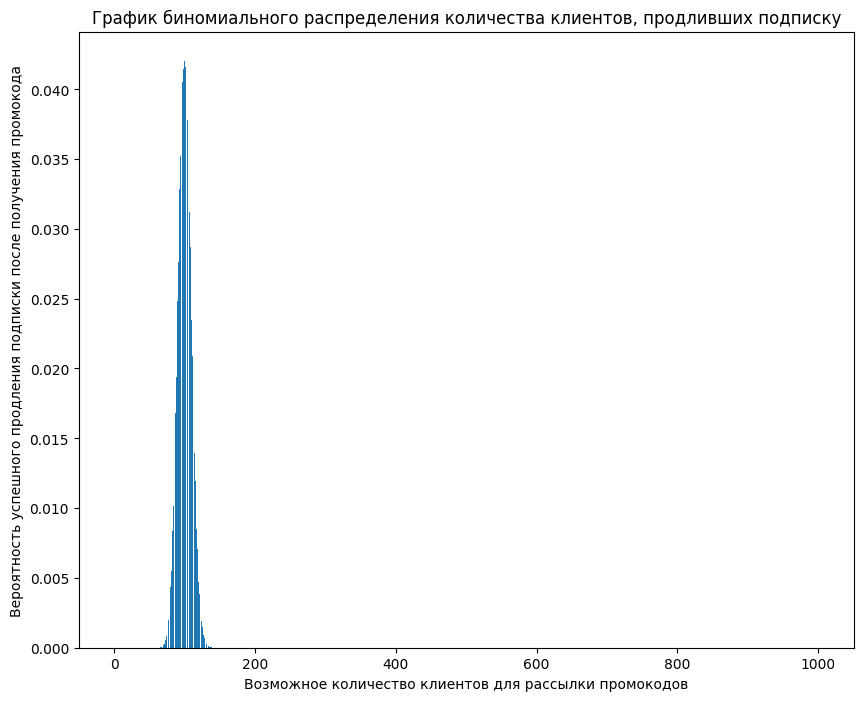

In [62]:
# Вероятность продления подписки после бесплатного пробного периода
p = 0.1

# Определим общее количество клиентов, которым придет промокод
n = 1000

# Создаем список, в котором будем хранить значения распределения
distr = []

# Построим распределение вероятностей
for k in range(0, n + 1):
    choose = factorial(n) / (factorial(k) * factorial(n - k))
    prob = choose * p**k * (1-p)**(n-k)
    distr.append(prob)

# Строим гистограмму распределения вероятностей
plt.bar(range(0, n+1), distr)

# Заголовок и подписи осей
plt.title('График биномиального распределения количества клиентов, продливших подписку')
plt.xlabel('Возможное количество клиентов для рассылки промокодов')
plt.ylabel('Вероятность успешного продления подписки после получения промокода')

plt.show()

Мы видим, что мат. ожидание стремится к показателю 100 клиентов при рассылке в 1000 клиентов

In [63]:
# Параметры биномиального распределения
n = 1171  # число испытаний, методом подбора по вероятности получить 100 и меньше
p = 0.1  # вероятность успеха
k = 100   # интересующее значение

# Расчет CDF
probability = binom.cdf(k, n, p)
print(f'Вероятность получить {k} или меньше успехов: {probability*100:.2f}% при количестве попыток {n}')

Вероятность получить 100 или меньше успехов: 5.05% при количестве попыток 1171


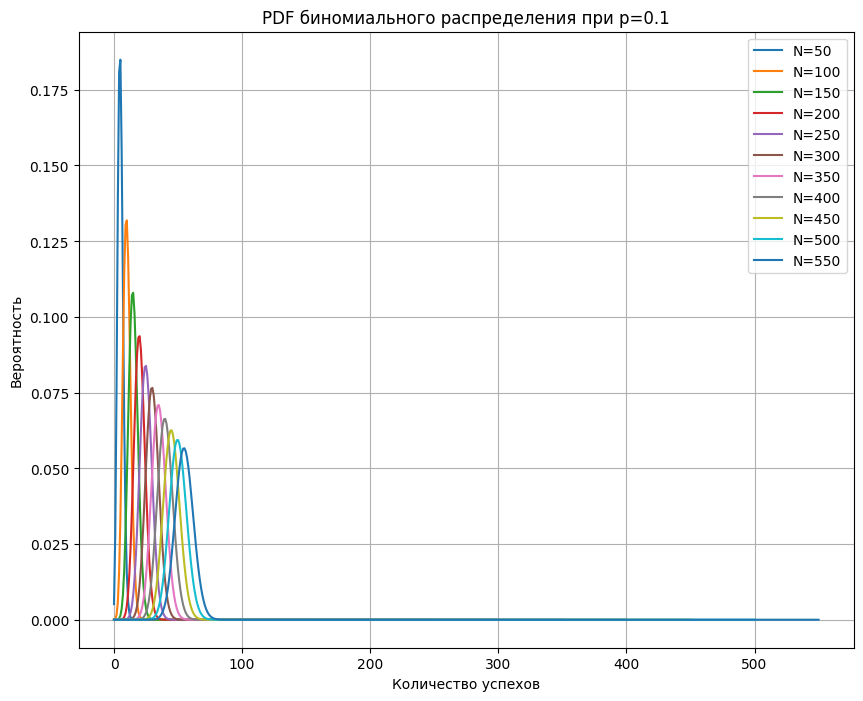

In [64]:
# Зададим условия распределения
p = 0.1
n_values = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550]  # Примерные значения N для сравнения

# Посмотрим на графики с разными N
for n in n_values:
    x = range(n + 1)
    probabilities = binom.pmf(x, n, p)
    plt.plot(x, probabilities, label=f'N={n}')

# Заголовок и подписи осей
plt.title('PDF биномиального распределения при p=0.1')
plt.xlabel('Количество успехов')
plt.ylabel('Вероятность')
plt.legend()
plt.grid()
plt.show()

Распределение PDF при вероятности 0.1 для разных n (ниже). Видно, что количество успехов 50 достигается при n примерно равному 550. Чтобы получить 100 успешных продлений, берем n в 2 раза больше. Выходим на вероятность 5% методом подбора параметра n. </div>

**Вывод:** чтобы вероятность не выполнить план продления подписок была примерно 5%, необходимо разослать 1171 промокод.

##### Рассылка push-уведомлений в мобильном приложении

**Условие задачи:**

* Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать.
* Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений.

**Вопрос:**
* С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

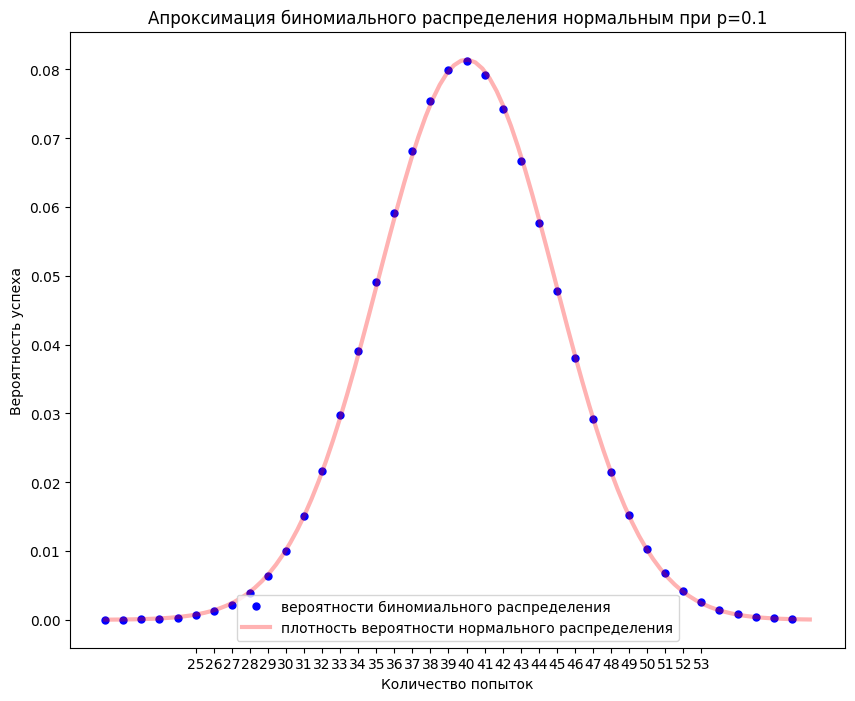

Условие выполняется


In [65]:
# зададим функцию, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>
# (понадобится для визуализации нормального распределения)
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result

# задаём параметры биномиального распределения
n = 100
p = 0.4

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))

# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))
# рисуем график биномиального распределения
ax = plt.subplot()
# используем синие о-образные маркеры и размер маркера 5
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=5, label='вероятности биномиального распределения')

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = linspace(left, right, 100)
# используем красную линию ширины 3 и прозрачности 0.3
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.3, label='плотность вероятности нормального распределения')

# зададим подписи по оси x в пределах ± 3 ст.отклонений от мат.ожидания
# (последний аргумент в методе range - интервал между подписями)
x_ticks = list(range(int(mu - 3 * sigma), int(mu + 3 * sigma), 1))
ax.set_xticks(x_ticks)

# настраиваем оптимальное расположение легенды и выводим график
ax.legend(loc='best')
# Заголовок и подписи осей
plt.title('Апроксимация биномиального распределения нормальным при p=0.1')
plt.xlabel('Количество попыток')
plt.ylabel('Вероятность успеха')
plt.legend()
plt.show()

# выводим, выполняется ли наше условие аппроксимации:
# лежит ли mu ± 3 sigma в промежутке от 0 до n:
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие выполняется')
else:
    print('Условие не выполняется')

In [66]:
# Задаем параметры биномиального распределения
n = 1_000_000
p = 0.4

# Зададим мат. ожидание и ст. отклонение нормального распределения
# равными мат. ожиданию и ст. отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1-p))

# Задаем нормальное распределение
distr = st.norm(mu, sigma)

# Считаем вероятность хвоста слева от 399,5 тыс. пользователей
result = distr.cdf(399_500)
print(f'Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей, составляет {result*100:.1f}%')

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей, составляет 15.4%


**Вывод:** вероятность того, что уведомление откроют не более 399,5 тыс. пользователей, составляет 15.4%

#### Общий вывод

**По итогам шага 1 проведена загрузка данных и ознакомление с датафреймами:**
* Объема датасета **`users`** 1_565 строк
* В столбцах отсутствуют пропущенные значения
* Тип данных в столбцах корректный
* Наименования столбцов прописаны корректно
* Столбец `user_id` также есть в датасете **`rides`**, столбец `subscription_type` - в датасете **`subscriptions`**


* Объема датасета **`rides`** 18_068 строк
* В столбцах отсутствуют пропущенные значения
* Тип данных в столбце `date` подлежит корректировке на тип datetime
* Наименования столбцов прописаны корректно
* Столбец `user_id` также есть в датасете **`users`**


* Объема датасета **`subscriptions`** 2 строки
* В столбцах отсутствуют пропущенные значения
* Тип данных в столбцах корректный
* Наименования столбцов прописаны корректно
* Столбец `subscription_type` также есть в датасете **`users`**
---
**По итогам шага 2 проведена предобработка данных:**
* В датасете **`rides`** тип данных для столбца `date` скорректирован на datetime
* В датасете **`rides`** создан новый столбец `date_month`
* В датасете **`users`** удалён 31 явный дубликат
* Пропущенные значения в датасетах не выявлены (см. п.1.2)
---
**По итогам шага 3 проведен исследовательский анализ данных:**
* Анализ пользователей по городам показал, что **чаще всего встречаются пользователи из Пятигорска, реже всего - из Москвы**.

* Анализ пользователей в рарезе наличия подписки показал, что **пользователи с подпиской составляют 54,4%, без подписки - 45,6%.**.

* Анализ возраста пользователей показал, что распределение возраста пользователей имеет пиковое значение на отметке 25 лет. Таким образом, **целевая аудитория это пользователи в возрасте от 23 до 27 лет**. Также есть пользователи в возрасте до 18 лет, которые по возрасту не должны ездить на самокатах.

* Анализ расстояний поездок показал, что **в среднем 1 пользователь проезжает 3 км**. Примечательно, что практически не встречаются пользователя, которые ездят более 6 км.

* Анализ средней продолжительности поездки показал, что **в среднем продолжительность поездки на 1 пользователя составляет 18 минут**.
---
**По итогам шага 4 проведено объединение данных:**
* в единый датафрейм объединены датасеты `users`, `rides`, `subscriptions`.
* разделены на 2 датафрейма данные по пользователям с подпиской и без подписки.
* построены гистограммы распределения расстояний и продолжительности поездок по пользователям с подпиской и без подписки.

На основе построенных графиков можно сделать следующие выводы:
* среднее расстояние поездки на 1 пользователя <u>без подписки</u> составляет 3114 метров, <u>с подпиской</u> - 3148 метра.
* средняя продолжительность поездки на 1 пользователя <u>без подписки</u> составляет 17 минут, <u>с подпиской</u> - 18 минут.
---
**По итогам шага 5 проведен подсчет выручки:**
* Создан датафрейм с агрегированными данными о поездках и посчитаны <u>для каждого пользователя за каждый месяц</u>:
    * выручка;
    * суммарное расстояние поездок;
    * суммарное время поездок;
    * количество поездок.
---
**По итогам шага 6 проведены проверки статистических гипотез, по результатам которых:**
* Отвергнута нулевая гипотеза: среднее время поездки 1 пользователя с подпиской значимо больше аналогичного показателя для пользователя без подписки
* Не отвергнута нулевая гипотеза: нет достаточных оснований утверждать, что среднее расстояние поездки 1 пользователя с подпиской значимо больше 3130 метров
* Отвергнута нулевая гипотеза: помесячная выручка от пользователей с подпиской значимо больше аналогичного показателя для пользователей без подписки
---
**По итогам шага 7 проанализированы кейсы, по результатам которых получены следующие инсайты:**
* Чтобы вероятность не выполнить план продления подписок была примерно 5%, необходимо разослать 1171 промокод.
* Вероятность того, что push-уведомление откроют не более 399,5 тыс. пользователей, составляет 15.4%